In [1]:
####### Calculation packages
####### 

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.linalg import pinv
import math
import random

####### Plotting packages
####### 

import seaborn as sns
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, FixedFormatter, FormatStrFormatter

####### Formatting packages
####### 

import warnings
from time import time as tm
#from google.colab import files

####### self-defined packages
####### 
from HelperFuns import *

np.random.seed(2023)

####### Plotting
sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
####### 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Setup

In [2]:
n = 200              # network size N = 200
G_nd= np.eye(n)      # connectivity matrix with diagnal = 1
invG_nd= np.eye(n) #inv(G_nd)   # to avoid multiple inverse calculations
m = 100#*5           # sample size (m>n, under-parameterized system)
sigma_x = .1
sigma_r = 0.01
X_nd = sigma_x*np.random.randn(n,m)

scale_stability = 0.5   # Girko's circular law
W_hat_nd = scale_stability*np.random.randn(n,n)*np.sqrt(1/n) # unit circle


A_hat_nd = inv(invG_nd - W_hat_nd) 
r_hat_nd = A_hat_nd@X_nd + sigma_r*np.random.randn(n,m) 


## this is for nD cost function
def W_nd_Costfun(Weight, G_nd, X_nd, r_hat_nd):
    A = inv(inv(G_nd) - Weight)
    return np.sum((A@X_nd-r_hat_nd)**2)/m

def A_nd_Costfun(A, X_nd, r_hat_nd):
    return np.sum((A@X_nd-r_hat_nd)**2)/m 

In [79]:

# Spectral radius for initial W
sigmaw=0.75

# Learning rates
eta_W = np.array([0.03, 0.1, .3, 1.0, 3.0])
eta_A = np.array([0.03, 0.1, .3, 1.0, 3.0])

# Number of iterations to do grad descent
niterations = int(1000*3.5)

# Initial W
W_init = (sigmaw/np.sqrt(n))*np.random.randn(n,n)

# Period for computing eigenvalues.
# Set to large number (larger than niterations) to avoid computing eigenvals
eigPeriod=1e9 # 20

# dW1 ###########################################################################
# initialize the loss
lossesdW1 = np.zeros((len(eta_W), niterations+1))
W = W_init.copy()
lossesdW1[:, 0] = W_nd_Costfun(W, G_nd, X_nd, r_hat_nd)
eigdW1 = np.zeros((len(eta_W),int(niterations/eigPeriod)+1,n),dtype=np.complex_)
eigdW1[:,0,:]=np.linalg.eig(W_init)[0]
startW =tm() # time stamped
for i in range(len(eta_W)): 
    W = W_init.copy()
    for j in range(niterations):
        A = inv(invG_nd - W) 
        AXnd = A@X_nd
        dJdW = -(2/m)*A.T@(AXnd-r_hat_nd)@(AXnd.T) # direct gradient descent updating rule
        W = W+eta_W[i]*dJdW
        lossesdW1[i, j+1]=W_nd_Costfun(W, G_nd, X_nd, r_hat_nd)
        if j%eigPeriod==0 and j>0:
            eigdW1[i,int(j/eigPeriod)+1,:]=np.linalg.eig(W)[0]
            
        
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )


# dW2 ###########################################################################

lossesdW2 = np.zeros((len(eta_A), niterations+1))
A = inv(invG_nd - W_init)
lossesdW2[:, 0] = A_nd_Costfun(A, X_nd, r_hat_nd)
eigdW2 = np.zeros((len(eta_W),int(niterations/eigPeriod)+1,n),dtype=np.complex_)
eigdW2[:,0,:]=np.linalg.eig(W_init)[0]

startW =tm() # time stamped
for i in range(len(eta_A)):  
    W = W_init.copy()
    A = inv(invG_nd - W)
    for j in range(niterations):        
        dJdA = -(2/m)*(A@X_nd - r_hat_nd)@X_nd.T
        A = A + eta_A[i]*dJdA
        dJdW = invG_nd-W-inv(inv(invG_nd-W)-(2/m)*eta_A[i]*(A@X_nd-r_hat_nd)@(X_nd).T)
        W = W + dJdW
        A = inv(invG_nd - W)
        lossesdW2[i, j+1] = A_nd_Costfun(A, X_nd, r_hat_nd)
        if j%eigPeriod==0 and j>0:
            eigdW2[i,int(j/eigPeriod)+1,:]=np.linalg.eig(W)[0]
        
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )


# dW3 ###########################################################################

lossesdW3 = np.zeros((len(eta_A), niterations+1))
W=W_init.copy()
lossesdW3[:, 0] = W_nd_Costfun(W,G_nd, X_nd,r_hat_nd)
eigdW3 = np.zeros((len(eta_W),int(niterations/eigPeriod)+1,n),dtype=np.complex_)
eigdW3[:,0,:]=np.linalg.eig(W_init)[0]

startW =tm() # time stamped
for i in range(len(eta_A)):
    W = W_init.copy()
    for j in range(niterations):
        dJdW = -(2/m)*eta_A[i]*(X_nd-(invG_nd-W)@r_hat_nd)@X_nd.T@(invG_nd-W)
        W = W + dJdW
        lossesdW3[i, j+1]=W_nd_Costfun(W, G_nd, X_nd, r_hat_nd)
        if j%eigPeriod==0 and j>0:
            eigdW3[i,int(j/eigPeriod)+1,:]=np.linalg.eig(W)[0]
        
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )



Time to generate gradient descent: 73.37 sec.
Time to generate gradient descent: 71.00 sec.
Time to generate gradient descent: 57.71 sec.


/var/folders/6t/fcfkw2p97jlgqfzgfmqhybt40000gr/T/ipykernel_24524/1752262154.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


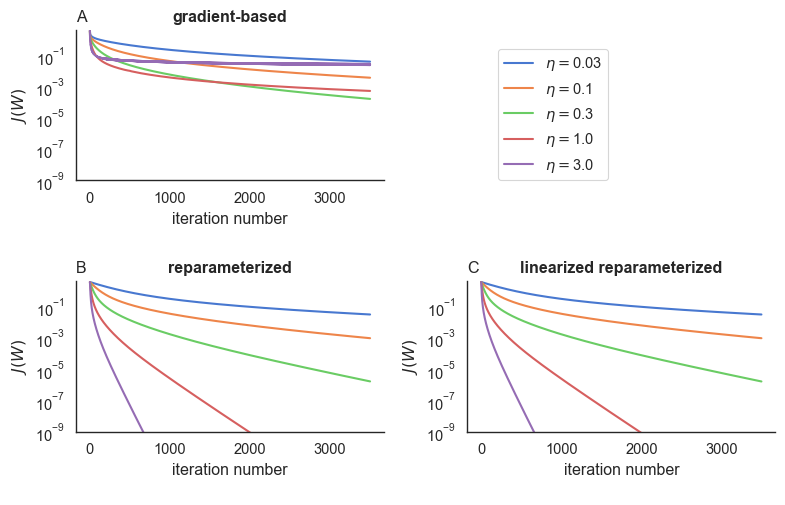

In [75]:
sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')

x = np.arange(0,niterations+1,1)

ylim0=[1e-9,lossesdW3.max()*1.1]

plt.subplots(figsize=(8,5.2))

plt.subplot(2,2,1)
for i in range(len(eta_W)):
    plt.plot(x,lossesdW1[i,:],label= r'$\eta = $' +  str(eta_W[i]))
plt.ylabel('$J(W)$')
plt.xlabel('iteration number\n')
sns.despine()
plt.ylim(ymin = 1e-5, ymax = 1e2)
#plt.legend()
plt.ylim(ylim0)
plt.yscale('log')
plt.title('A',loc='left')
plt.title('gradient-based',loc='center',weight='bold')

# Make an empty plot to get legend in top-right subplot space
plt.subplot(2,2,2)
for i in range(len(eta_W)):
    plt.plot(x,x,label= r'$\eta = $' +  str(eta_W[i]))
plt.legend(loc=(.1,0))
plt.axis('off')
plt.xlim(-10,-5)


plt.subplot(2,2,3)
for i in range(len(eta_A)):
    plt.plot(x,lossesdW2[i,:],label= r'$\eta_W = $' +  str(eta_A[i]))
plt.ylabel('$J(W)$')
plt.xlabel('iteration number\n')
sns.despine()
#plt.legend(loc=(1,.1))
plt.ylim(ylim0)
plt.yscale('log')
plt.title('B',loc='left')
plt.title('reparameterized',loc='center',weight='bold')

plt.subplot(2,2,4)
for i in range(len(eta_A)):
    plt.plot(x,lossesdW3[i,:],label= r'$\eta_W = $' +  str(eta_A[i]))
plt.ylabel('$J(W)$')
plt.xlabel('iteration number')
sns.despine()
#plt.legend(loc=(1,.1))
plt.ylim(ylim0)
plt.yscale('log')
plt.title('C',loc='left')
plt.title('linearized reparameterized',loc='center',weight='bold')

plt.tight_layout()

plt.savefig('../Figures/LinearNDdW123.pdf')


In [105]:

# Number of iterations to do grad descent
niterations = int(1000*3.5)

# Initial W
W_init = (sigmaw/np.sqrt(n))*np.random.randn(n,n)
W = W_init.copy()
r = np.linalg.solve((invG_nd - W), X_nd)

eta_A = np.array([0.03, 0.1, .3, 1.0, 3.0])

startW =tm() # time stamped
angles12 = np.zeros((len(eta_A), niterations))
x = np.arange(0,niterations,1)
for i in range(len(eta_A)):  
    W = W_init.copy()
    for j in range(niterations):   
        dJdW2 = -invG_nd+W+inv(inv(invG_nd-W)-(2/m)*eta_A[i]*(r-r_hat_nd)@(X_nd).T)
        dJdW1 = (inv(invG_nd - W)).T@(r-r_hat_nd)@(r.T)
        r = np.linalg.solve((invG_nd - W), X_nd)
        # then compute angle
        cos_of_angle = np.sum(dJdW1*dJdW2)/np.sqrt(np.sum(dJdW1*dJdW1)*np.sum(dJdW2*dJdW2))
        angles12[i,j] = np.arccos(np.clip(cos_of_angle,-1,1))  * 180/np.pi
        W = W - dJdW2
 ######################################### Angle plot A #########################################         
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )



# To find solutions near W_target, take W_init=w[0]*W1 + (1-w[0])*W0
W = W_init.copy()
startW =tm() # time stamped
angles23 = np.zeros((len(eta_A), niterations))
cor = np.zeros((len(eta_A), niterations))
x = np.arange(0,niterations,1)
for i in range(len(eta_A)):  
    W = W_init.copy()
    for j in range(niterations):
        # first compute dW2 for the update
        dJdW2 = -invG_nd+W+inv(inv(invG_nd-W)-(2/m)*eta_A[i]*(r-r_hat_nd)@(X_nd).T)
        dJdW3 = (2/m)*eta_A[i]*(X_nd-(invG_nd-W)@r_hat_nd)@X_nd.T@(invG_nd-W)
        r = np.linalg.solve((invG_nd - W), X_nd)
        
        # then compute angle
        cos_of_angle = np.sum(dJdW2*dJdW3)/np.sqrt(np.sum(dJdW2*dJdW2)*np.sum(dJdW3*dJdW3))
        angles23[i,j] = np.arccos(np.clip(cos_of_angle,-1,1))  * 180/np.pi
        W = W -dJdW3
stopW = tm()
print("Time to generate gradient descent: %.2f sec." %(stopW-startW) )  




Time to generate gradient descent: 73.04 sec.
Time to generate gradient descent: 74.88 sec.


/var/folders/6t/fcfkw2p97jlgqfzgfmqhybt40000gr/T/ipykernel_24524/3706815176.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


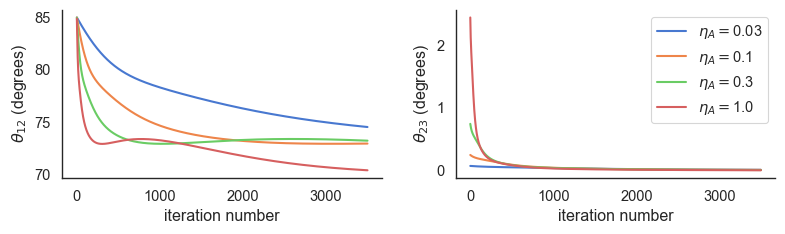

In [107]:
sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
plt.subplots(figsize=(8,2.5))

plt.subplot(1,2,1)
for i in range(len(eta_A)-1):
    plt.plot(x[1:],angles12[i,1:],label= r'$\eta_A = $' +  str(eta_A[i]))    
#plt.title('A',loc='left',pad=10)
plt.ylabel(r'$\theta_{12}$ (degrees)')
plt.xlabel('iteration number')
sns.despine()    

plt.subplot(1,2,2)
for i in range(len(eta_A)-1):
    plt.plot(x[1:],angles23[i,1:],label= r'$\eta_A = $' +  str(eta_A[i]))    
plt.ylabel(r'$\theta_{23}$ (degrees)')
plt.xlabel('iteration number')
sns.despine()    
plt.legend(loc='best')

plt.tight_layout()

plt.savefig('../Figures/LinearNDangle.pdf')